<a href="https://colab.research.google.com/github/taresadere/taresadere/blob/main/last_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

In [ ]:
!pip install keras

In [ ]:
!pip install keras.applications.resnet50

ERROR: Could not find a version that satisfies the requirement keras.applications.resnet50 (from versions: none)
ERROR: No matching distribution found for keras.applications.resnet50


In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
img_width, img_height = 224, 224

In [ ]:
# Declarations
from keras import backend
train_path = "drive/My Drive/train"
valid_path ="drive/My Drive/validation"
test_path = "drive/My Drive/test"
IMAGE_SIZE=(224, 224)
from keras.preprocessing import image
classes= ["normal", "follicular", "intense", "scar", "trichiasis", "corneal opacity"]
def model_predict(img_path, model):
    image = cv2.imread(img_path)
    #image = cv2.resize(image, (224, 224))
    image = cv2.resize(image,   IMAGE_SIZE)
    image = image.astype("float") / 255.0
    #image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    res = model.predict(image)
    label = np.argmax(res)
    print("Label", label)
    labelName = classes[label]
    print("Label name:", labelName)
    return labelName
batch_size = 32
EPOCHS = 10
RANDOM_SEED = 42

if backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMAGE_SIZE[0], IMAGE_SIZE[1],1)
else:
    INPUT_SHAPE = (1,IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

print(f'input_shape: {INPUT_SHAPE}')

# useful for getting number of output classes
count_of_classes = len(glob(train_path+'/*'))
print(count_of_classes)

input_shape: (1, 224, 224, 3)
6


In [ ]:
# Prepare train/test using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = tuple(IMAGE_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = tuple(IMAGE_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 179 images belonging to 6 classes.
Found 55 images belonging to 6 classes.


In [ ]:
import tensorflow as tf
ResNet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=())

In [ ]:
ResNet_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in ResNet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
x=tf.keras.layers.Input((1,224, 224, 3))
x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
output  = Dense(units=6, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]
# Fine-tune
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
# fit the model, it will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)
print('Training time: %s' % (now() - t))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
6/6 [==============================] - 194s 35s/step - loss: 1.7692 - accuracy: 0.2570 - val_loss: 1.8785 - val_accuracy: 0.1818
Epoch 2/10
6/6 [==============================] - 4s 686ms/step - loss: 1.5598 - accuracy: 0.3352 - val_loss: 1.8831 - val_accuracy: 0.1818
Epoch 3/10
6/6 [==============================] - 4s 689ms/step - loss: 1.4588 - accuracy: 0.3240 - val_loss: 1.8909 - val_accuracy: 0.1818
Epoch 4/10
6/6 [==============================] - 4s 684ms/step - loss: 1.3827 - accuracy: 0.4190 - val_loss: 1.8928 - val_accuracy: 0.1818
Epoch 5/10
6/6 [==============================] - 4s 745ms/step - loss: 1.1814 - accuracy: 0.5419 - val_loss: 1.9041 - val_accuracy: 0.1818
Epoch 6/10
6/6 [==============================] - 4s 684ms/step - loss: 1.0446 - accuracy: 0.5419 - val_loss: 1.8822 - val_accuracy: 0.1818
Epoch 7/10
6/6 [==============================] - 4s 698ms/step - loss: 0.9754 - accuracy: 0.6201 - val_loss: 1.8867 - val_accuracy: 0.1818
Epoch 8/10
6/6 [====

In [ ]:
model.save('C:/Users/Dare/Desktop/TDCN GUI/models/resnet.h5')

In [ ]:
model.save_weights('resnet.hdf5')

In [ ]:
from keras.models import load_model
model = load_model("drive/My Drive/resnet50.h5")

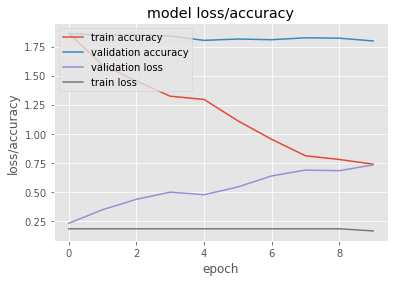

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
N= 100
plt.style.use("ggplot")
plt.figure()
plt.plot( r.history["loss"], label="train loss")
plt.plot( r.history[" val_loss"], label="val_loss")
plt.plot( r.history["accuracy"], label="train accuracy")
plt.plot( r.history["val_accuracy"], label="val_accuracy")
plt.title("training loss and Accuracy)
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("drive/My Drive/res")

#  making prediction and classification report





In [ ]:
y_predict = model.predict(valid_set)

In [ ]:
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc
from PIL import Image
y_pred=model.predict_generator(generator=valid_set,)
y_pred=np.argmax(y_pred,axis=1)
print('classification report')
print(classification_report(valid_set.classes, y_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


classification report
              precision    recall  f1-score   support

           0       0.20      1.00      0.34        11
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         6

    accuracy                           0.20        55
   macro avg       0.03      0.17      0.06        55
weighted avg       0.04      0.20      0.07        55

confusion matrix
[[11  0  0  0  0  0]
 [ 8  0  0  0  0  0]
 [10  0  0  0  0  0]
 [ 9  0  0  0  1  0]
 [10  0  0  0  0  0]
 [ 6  0  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




```
# This is formatted as code
```
plot confusion matrix 

In [ ]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
import seaborn as sns
def plot_confusion_matrix(normalize):
  classes = ['normal','follicular', 'intense', 'scar', 'trichiasis','corneal opacity']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(test_set.classes, y_pred, normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

Confusion Matrix without Normalization


NameError: ignored